# Algorithmic Friendship --- From the view of meetup

In Weeplace datast, we have true friendship network and now we would like to produce some friendship network according to meetup. 


*  **Assumuption** -- Friends always meet up at some locations along the time

* **Corollary**-- We can take advantage of the meetup records to generate an algorithmic friendship network

## Step 1 -- detect all the meetups (check-in at the same 1-hour bin in the same placeid) 

This part cannot run in graph-tool kernel, details please refer to *Co-Loc-friendship.ipnb*

In [ ]:
import pandas as pd
from math import log, e
import time
import pickle
import graph_tool.all as gt
import numpy as np

In [ ]:
""" Data pre-processing """
# df_full = pd.read_csv("data/weeplace_checkins.csv")
# # df_full = df_full.dropna(subset=["placeid"])
# # full dataset only removing NA location
# df_full = ft.read_dataframe('data/weeplace_checkins_without_loc_NA.feather')

# make new dataframe removing minutes and seconds information, called df_hour
# df_full['datetime'] = pd.to_datetime(df_full['datetime']).dt.floor('H')
# ft.write_dataframe(df_full, 'data/weeplace_checkins_hour_without_loc_NA.feather')
# # full dataset removing NA location and group the time into 1-hour bin
# import feather as ft 
# it looks package feather is not compatible to graph-tool, you can do it in Python 3 kernel or just import .csv dataset
df_hour = ft.read_dataframe('data/weeplace_checkins_hour_without_loc_NA.feather')
df_friend = pd.read_csv('data/weeplace_friends.csv')

In [ ]:
# username = df_hour['userid'].unique().tolist()
# N_users = len(username)

# start_time = time.time()
# # allocate space for object array
# meetup_store = np.empty(N_users, dtype=object)

# counter = 1
# for id in username[0:20]:
#     ego = df_hour[df_hour['userid'] == id][['userid', 'placeid', 'datetime']]
#     alter = df_hour[df_hour['userid']!=id][['userid', 'placeid', 'datetime']]
    
#     meetup = ego.merge(alter, how='left', on =['placeid', 'datetime'])\
#     .dropna()[['userid_x','placeid', 'userid_y']].groupby(['userid_x','userid_y'])['placeid']\
#     .count().reset_index(name='count').sort_values('count', ascending=False)
    
#     meetup[['percent']] = meetup[['count']]/meetup['count'].sum()
#     meetup_store[username.index(id)]=meetup
# #     names = 'user' + str(counter)
# #     meetup.to_hdf('meetup.h5', key=names, mode='a', complib ='blosc:zstd',complevel=9)
# #     print(counter)
#     counter += 1


# # save pickle file
# pickle_out = open("meetup_store.pickle", "wb")
# pickle.dump(meetup_store, pickle_out)
# pickle_out.close()

# elapsed_time = time.time() - start_time

import pickle
# read picle file
pickle_in = open("meetup_store.pickle", "rb")
meetup_store = pickle.load(pickle_in)

## Step 2 -- decide what is friend based on meetups

We define Artificial Friend Rate (AFR), which means which parts of co-occurance individuals should be friends.
* All the individuals who have meetups, even only once, should be friends, this is a definition
* Part of individuals, who have meetups, for example, several top frequent meetup people, should be friends, this is another definition 

In [5]:
# AFR = 0.07 ceil function + 1
import math

# x is the number of total meetups
def AFR(x, mode):
    switcher = {
        'all' : x,
        'threshold' : 1 if x<=2 else math.ceil(0.07*x) + 1,        
    }
    return switcher.get(mode)

test = [3, 5, 21, 77, 220]
for i in test:
    print(AFR(i, 'threshold'), AFR(i, 'all'))

2 3
2 5
3 21
7 77
17 220


Using AFR function, we can filter meetup and build algorithmic friendship network, details please refer to Co-Loc-friendship.ipnb. The results are already in the following .csv files.

## Step 3 -- import friendship network

In [6]:
g_true = gt.load_graph_from_csv('data/weeplace_friends.csv', skip_first=True, directed=False, hashed=True)

In [7]:
g_threshold = gt.load_graph_from_csv('data/weeplace_artifical_friend_threshold_gt.csv', skip_first=True, directed=False, hashed=True)

In [8]:
g_all = gt.load_graph_from_csv('data/weeplace_artifical_friend_all_gt.csv', skip_first=True, directed=False, hashed=True)

## Step 4 -- Network visualisation

### True friendship network

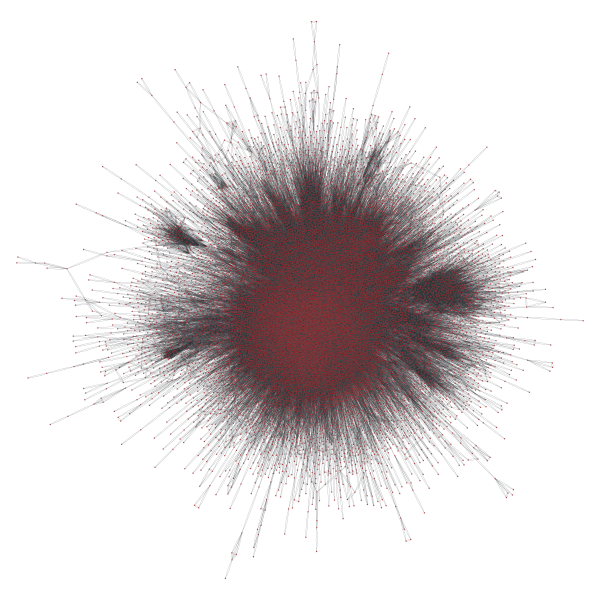

<VertexPropertyMap object with value type 'vector<double>', for Graph 0x7fd878f204a8, at 0x7fd878f19048>

In [9]:
# true friendship network
gt.graph_draw(g_true)

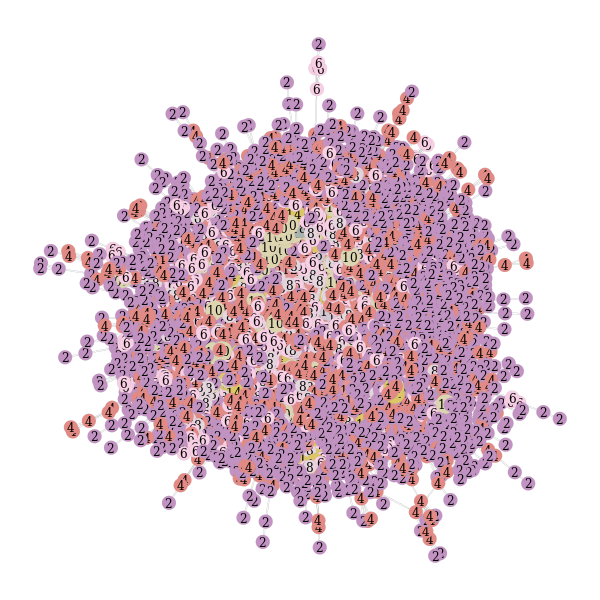

<VertexPropertyMap object with value type 'vector<double>', for Graph 0x7fd878f204a8, at 0x7fd878e9d198>

In [10]:
kcore_true = gt.kcore_decomposition(g_true)
gt.graph_draw(g_true, vertex_fill_color=kcore_true, vertex_text=kcore_true)

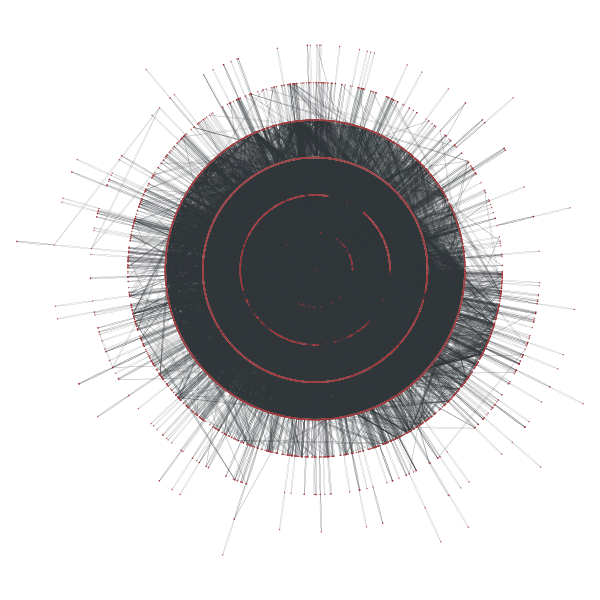

<VertexPropertyMap object with value type 'vector<double>', for Graph 0x7fd878f204a8, at 0x7fd8786814e0>

In [11]:
pos_true = gt.radial_tree_layout(g_true, g_true.vertex(0))
gt.graph_draw(g_true, pos=pos_true)

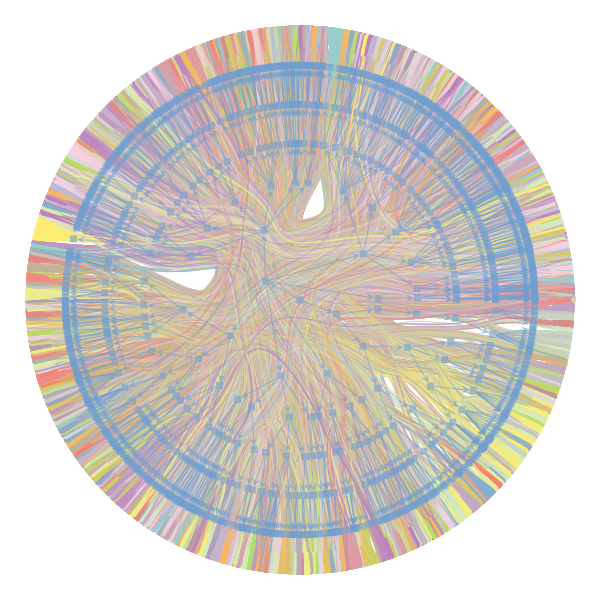

(<VertexPropertyMap object with value type 'vector<double>', for Graph 0x7fd878f204a8, at 0x7fd878585c88>,
 <Graph object, directed, with 17152 vertices and 17151 edges at 0x7fd878681d68>,
 <VertexPropertyMap object with value type 'vector<double>', for Graph 0x7fd878681d68, at 0x7fd878681240>)

In [12]:
state_true = gt.minimize_nested_blockmodel_dl(g_true, deg_corr=True)
gt.draw_hierarchy(state_true)

### Artifical Friendship Network (AFR = 7%)

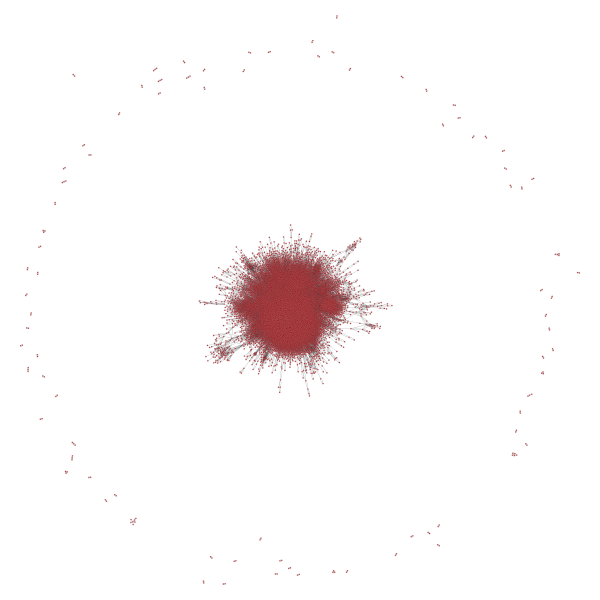

<VertexPropertyMap object with value type 'vector<double>', for Graph 0x7fd878f205f8, at 0x7fd87931a2e8>

In [13]:
gt.graph_draw(g_threshold)

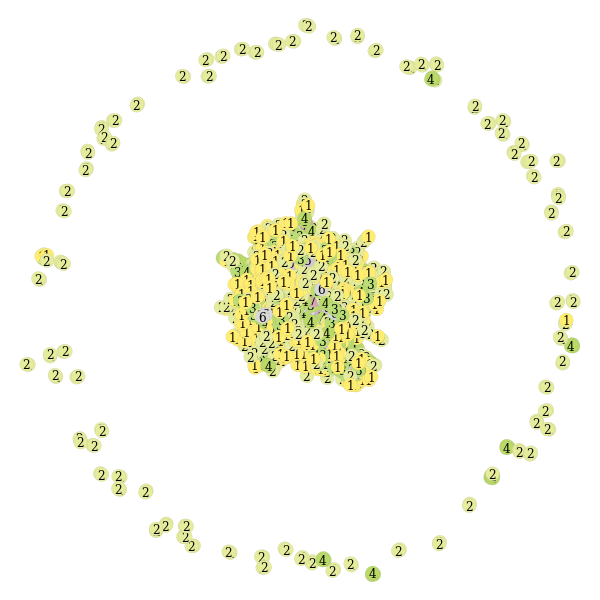

<VertexPropertyMap object with value type 'vector<double>', for Graph 0x7fd878f205f8, at 0x7fd8b6a55c88>

In [14]:
kcore_threshold = gt.kcore_decomposition(g_threshold)
gt.graph_draw(g_threshold, vertex_fill_color=kcore_threshold, vertex_text=kcore_threshold)

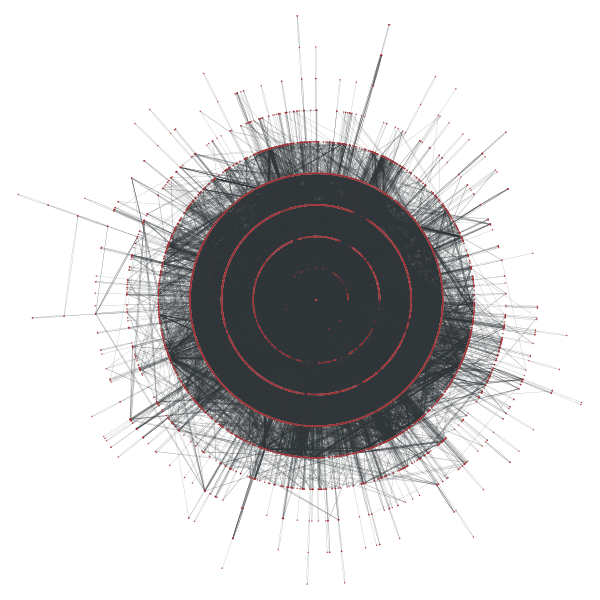

<VertexPropertyMap object with value type 'vector<double>', for Graph 0x7fd878f205f8, at 0x7fd878eb32b0>

In [15]:
pos_threshold = gt.radial_tree_layout(g_threshold, g_threshold.vertex(0))
gt.graph_draw(g_threshold, pos=pos_threshold)

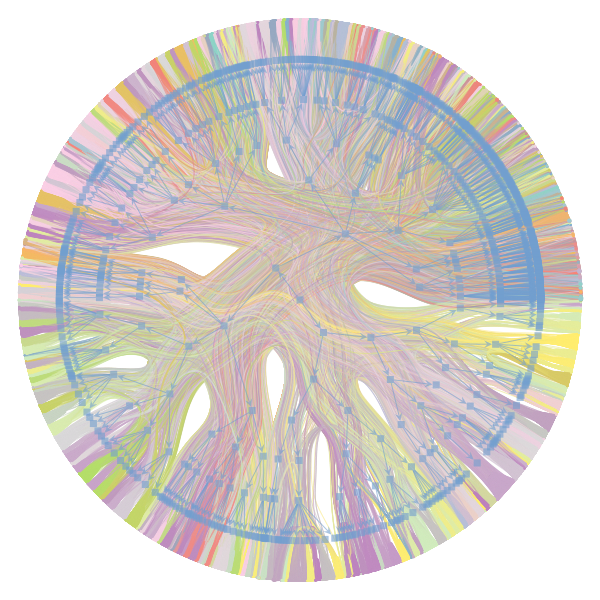

(<VertexPropertyMap object with value type 'vector<double>', for Graph 0x7fd878f205f8, at 0x7fd878cf7c18>,
 <Graph object, directed, with 15166 vertices and 15165 edges at 0x7fd8786819e8>,
 <VertexPropertyMap object with value type 'vector<double>', for Graph 0x7fd8786819e8, at 0x7fd878681748>)

In [16]:
state_threshold = gt.minimize_nested_blockmodel_dl(g_threshold, deg_corr=True)
gt.draw_hierarchy(state_threshold)

### Artifical Friendship Network (AFR = 1)

In [ ]:
gt.graph_draw(g_all)

In [ ]:
kcore_all = gt.kcore_decomposition(g_all)
gt.graph_draw(g_all, vertex_fill_color=kcore_all, vertex_text=kcore_all)

In [ ]:
pos_all = gt.radial_tree_layout(g_all, g_all.vertex(0))
gt.graph_draw(g_all, pos=pos_all)

In [ ]:
state_all = gt.minimize_nested_blockmodel_dl(g_all, deg_corr=True)
gt.draw_hierarchy(state_all)

In [ ]:
# print(g2.vp.keys())
# print(g2.ep.keys())
# print([g2.vp['name'][v] for v in g2.get_vertices()])

## Step 5 -- Compare with different friendship network

In its default parametrization, the adjacency similarity is the sum of equal non-zero entries in the adjacency matrix, given a vertex ordering determined by the vertex labels. In other words, it counts the number of edges which have the same source and target labels in both graphs. This function also allows for generalized similarities according to an $L^p$ norm, for arbitrary p.

In [17]:
p_norm = 1 # currently we set p_norm = 1 

In [21]:
import seaborn as sns
import matplotlib.pyplot as plt

In [18]:
# adjacency similarity matrix construction

S_True_All = gt.similarity(g_true,g_all,p=p_norm)
S_True_Threshold = gt.similarity(g_true,g_threshold,p=p_norm)
S_Threshold_All = gt.similarity(g_threshold,g_all,p=p_norm)

adj_similarity = pd.DataFrame.from_dict({
    'TF': [1, S_True_Threshold, S_True_All],
    'AFR-T': [S_True_Threshold, 1, S_Threshold_All],
    'AFR-A': [S_True_All, S_Threshold_All, 1]
}, orient='index')

In [19]:
adj_similarity.columns = ['TF', 'AFR-T', 'AFR-A']
adj_similarity

,TF,AFR-T,AFR-A
TF,1.000000,0.009080,0.008505
AFR-T,0.009080,1.000000,0.013178
AFR-A,0.008505,0.013178,1.000000


In [ ]:
print(gt.similarity(g_true,g_all,p=1), gt.similarity(g_true,g_threshold,p=1), gt.similarity(g_threshold,g_all,p=1))

In [ ]:
print(gt.similarity(g_true,g_all,p=2), gt.similarity(g_true,g_threshold,p=2), gt.similarity(g_threshold,g_all,p=2))

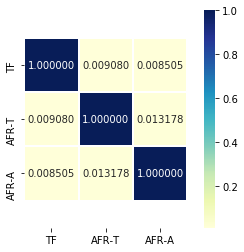

In [22]:
ax = sns.heatmap(adj_similarity,annot=True,linewidths=1,cmap="YlGnBu", fmt='f', square=True)
ax.set_aspect("equal")
b, t = plt.ylim() # discover the values for bottom and top
b += 0.5 # Add 0.5 to the bottom
t -= 0.5 # Subtract 0.5 from the top
plt.ylim(b, t) # update the ylim(bottom, top) values
plt.show() # ta-da!